In [8]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.float_format = "{:,.2f}".format
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import warnings
warnings.simplefilter("ignore")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [14]:
train = pd.read_parquet(os.path.join('../data/', 'train.parquet'))
#train['event_time'] = pd.to_datetime(train['event_time'], format='%Y-%m-%d %H:%M:%S %Z')

train = train.sort_values(by=['user_session','event_time'])
train_df = train[['user_id','item_id','user_session','event_time','category_code', 'brand','price','event_type']]
#train_df['event_time'] = train_df['event_time'].values.astype(float)

In [35]:
#user defined functions
def extract_categorycode(input_text,level=1):
    '''
     this function splits category code and returns the first part.
    '''
    output_text=input_text.split('.')[level]
    return output_text

def create_clusters(input_data_frame,input_columns,n_cluster):
    '''
     This function creates clusters and cluster labels.
    '''
    from sklearn.cluster import KMeans
    X=input_data_frame[input_columns].values
    k_means=KMeans(n_clusters=n_cluster,random_state=15).fit(X)
    return k_means.labels_

In [17]:
dataset = train_df.copy()

In [51]:
dataset['category_code'].value_counts()

category_code
apparel.shoes                 2960539
apparel.shoes.keds            1035117
apparel.shoes.slipons          756754
apparel.shoes.sandals          592478
apparel.costume                424789
apparel.underwear              413119
apparel.scarf                  380521
apparel.shirt                  346004
apparel.shoes.moccasins        259753
apparel.shorts                 192148
apparel.shoes.step_ins         172520
apparel.trousers               150486
apparel.tshirt                 134430
apparel.jeans                   91158
apparel.shoes.ballet_shoes      78157
apparel.pajamas                 75274
apparel.jumper                  67274
apparel.dress                   65851
apparel.sock                    45491
apparel.shoes.espadrilles       41941
apparel.glove                   32365
apparel.skirt                   23283
apparel.jacket                   5602
apparel.belt                     5257
Name: count, dtype: int64

In [18]:
dataset['category_code']=dataset['category_code'].astype('category')
dataset['event_time'] = pd.to_datetime(dataset['event_time'], format='%Y-%m-%d %H:%M:%S %Z', utc=True)

In [21]:
#creating a summary table for general overview
daily_summary_table=dataset.groupby(by=[dataset['event_time'].dt.normalize()]).agg(Number_of_daily_visits=('user_session',lambda x: x.nunique()),
                                                                                  Number_of_daily_visitors=('user_id',lambda x: x.nunique())
                                                                                  )
sales_filter=dataset['event_type']=='purchase'
sales=dataset.loc[sales_filter].groupby(by=[dataset['event_time'].dt.normalize()]).agg(number_of_daily_sales=('event_type','count'),
                                                                                      Total_daily_sales=('price','sum')
                                                                                      ).reset_index()
daily_summary_table=pd.merge(left=daily_summary_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')
daily_summary_table['conversion_rate']=daily_summary_table['number_of_daily_sales']/daily_summary_table['Number_of_daily_visits']

## General Summary

Daily Visits Statistics
--------------------------------------------------
count      121.00
mean    23,951.49
std     11,395.98
min      4,254.00
25%     19,599.00
50%     26,230.00
75%     30,182.00
max     51,608.00
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
Visit Statistics by Dates
--------------------------------------------------
            count      mean       std      min       25%       50%       75%  \
event_time                                                                     
Friday      18.00 23,282.28 11,533.78 4,254.00 15,807.25 26,450.00 29,752.25   
Monday      17.00 25,045.24 12,396.05 5,466.00 24,189.00 26,394.00 28,758.00   
Saturday    18.00 23,160.28 11,278.52 4,852.00 16,588.50 25,702.50 30,638.75   
Sunday      17.00 25,209.71 10,781.06 4,928.00 22,724.00 26,522.00 30,182.00   
Thursday    17.00 23,371.71 12,123.11 5,047.00 10,914.00 26,762.00 30,384.00   
Tuesday     17.00 24,009.35 11,707.34 6,213.00 2

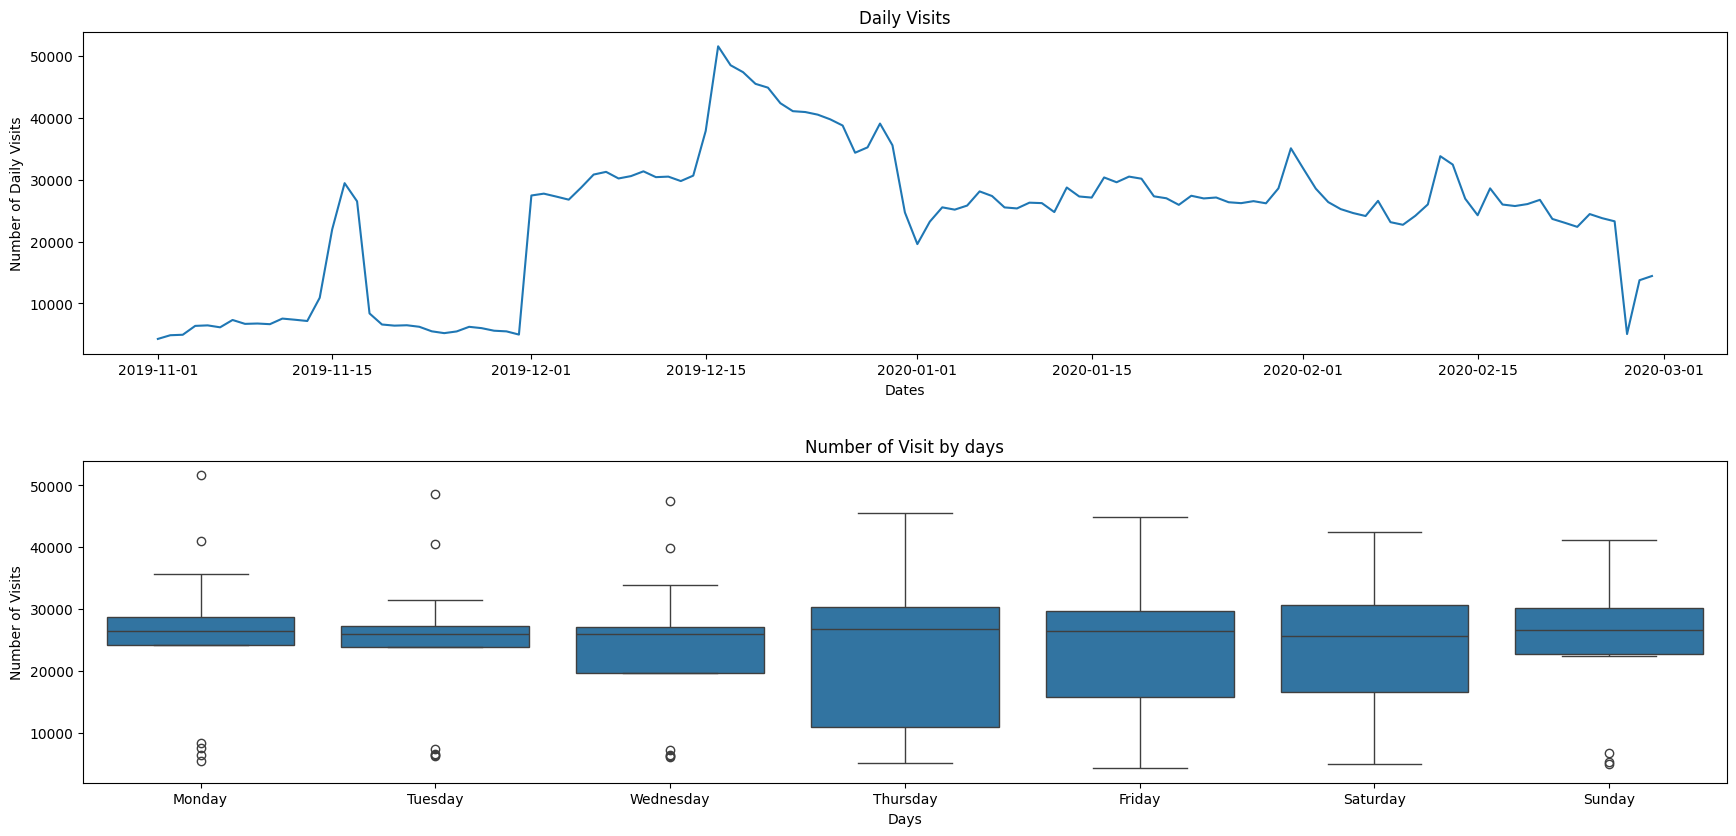

In [22]:
#Daily Visits
print('Daily Visits Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visits'].describe())
print('-'*50)
print('Visit Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['Number_of_daily_visits'].describe())

#Plotting number of daily visits
fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_summary_table,
             ax=ax1)
plt.title('Daily Visits')
plt.ylabel('Number of Daily Visits')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='Number_of_daily_visits',
            data=daily_summary_table,
           ax=ax2)
plt.title('Number of Visit by days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

- 1. 일일방문수: 2019년에 비해 2020년도에 방문수가 많고 특정일 튀는 날이 존재함. 해당 구간 top item 분석 필요
- 2. 요일별 방문수: 목,금,토 top item 분석 후 해당 요일 지표 추가 결정 필요

Conversion Rates Statistics
--------------------------------------------------
count   90.00
mean     0.00
std      0.01
min      0.00
25%      0.00
50%      0.00
75%      0.00
max      0.13
Name: conversion_rate, dtype: float64
--------------------------------------------------
Conversion Rates Statistics by Dates
--------------------------------------------------
            count  mean  std  min  25%  50%  75%  max
event_time                                           
Friday      14.00  0.00 0.01 0.00 0.00 0.00 0.00 0.03
Monday      13.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00
Saturday    12.00  0.00 0.01 0.00 0.00 0.00 0.00 0.02
Sunday      12.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00
Thursday    12.00  0.01 0.04 0.00 0.00 0.00 0.00 0.13
Tuesday     13.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00
Wednesday   14.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00


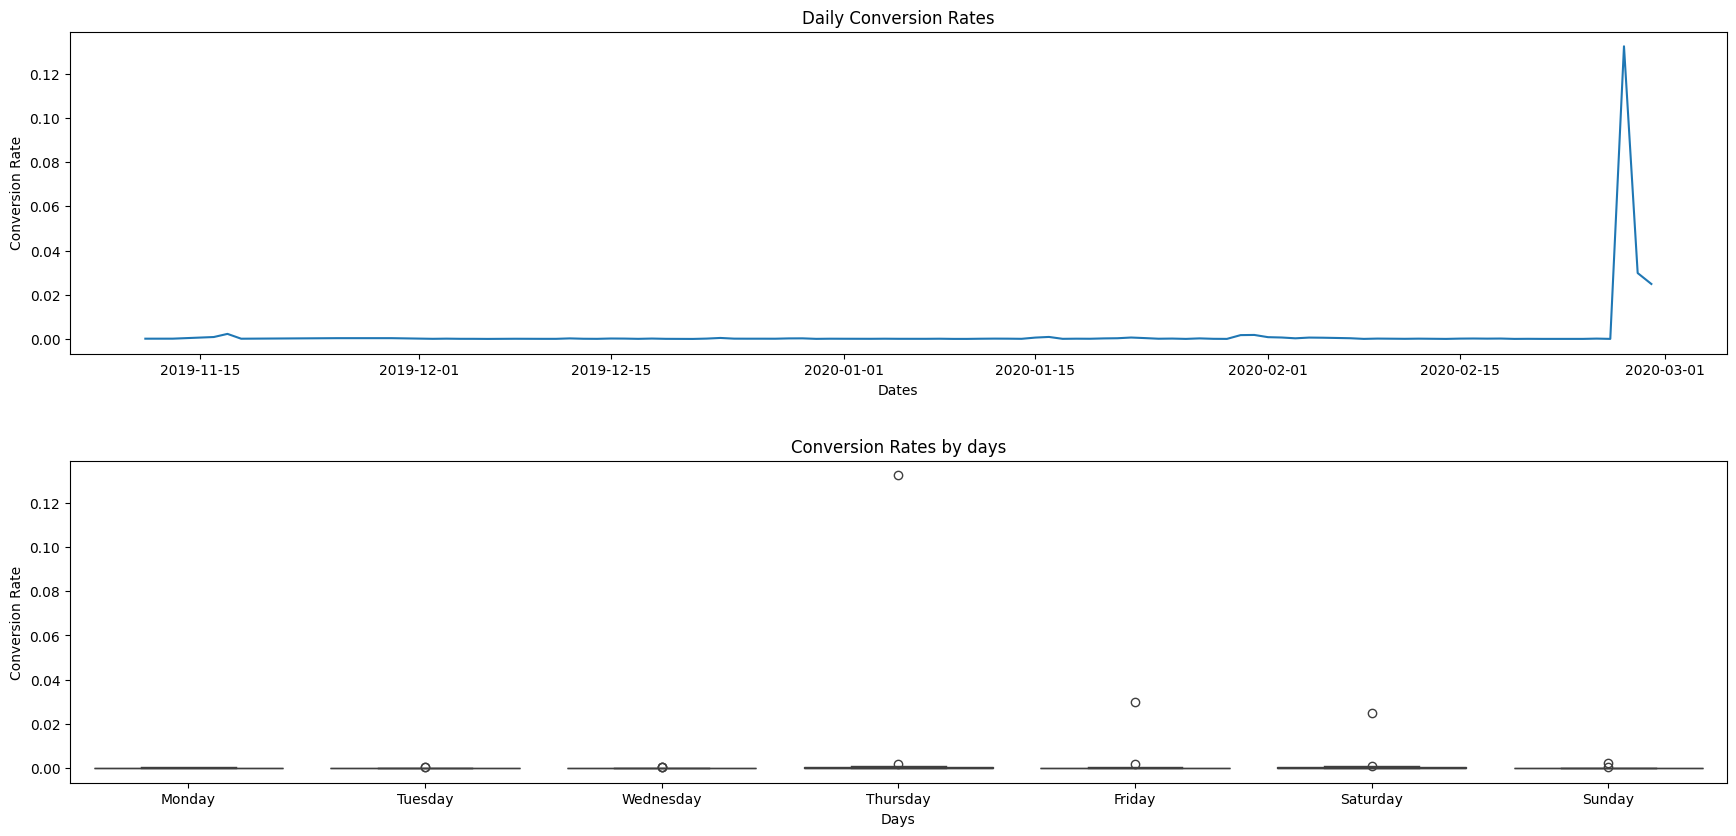

In [24]:
#Conversion rates
print('Conversion Rates Statistics')
print('-'*50)
print(daily_summary_table['conversion_rate'].describe())
print('-'*50)
print('Conversion Rates Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['conversion_rate'].describe())

#Plotting convergance rates
fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='conversion_rate',
              data=daily_summary_table,
            ax=ax1)
plt.title('Daily Conversion Rates')
plt.ylabel('Conversion Rate')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='conversion_rate',
            data=daily_summary_table,
           ax=ax2)
plt.title('Conversion Rates by days')
plt.ylabel('Conversion Rate')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

- 1. 일일 전환율: 2020년 2월 말에 전환율이 높은 이유 분석 필요
- 2. 요일별 전환율: 방문수가 많은 목, 금, 토 요일에 전환율이 많음

## Customer Analytics

In [28]:
#creating a customer table
#Filtering sales activities
sales_filter=dataset['event_type']=='purchase'
Customer_table=dataset.loc[sales_filter].groupby(by=['user_id']).agg(number_of_purchases=('user_id','count'),
                                                                     total_sales=('price','sum')).reset_index()


In [29]:
#Calculating number of customers who bought something
Number_of_customers_who_bought_smt=Customer_table['user_id'].nunique()
print('There are {:,.0f} customers, who purchased in 2019/11~ 2020/2'.format(Number_of_customers_who_bought_smt))

#Calculating number of purchase activities for each customer
print('-'*50)
print('Distribution of Customer by Number of Purchases')
print(Customer_table['number_of_purchases'].value_counts(normalize=True).head(10))
#Calculationg repeat customers number
print('-'*50)
more_than_one_purchase_filter=Customer_table['number_of_purchases']>1
Number_of_customers_who_bought_more_than_once=Customer_table.loc[more_than_one_purchase_filter].shape[0]
print('There are {:,.0f} repeat customers, who bought more than once.'.format(Number_of_customers_who_bought_more_than_once))

There are 1,681 customers, who purchased in 2019/11~ 2020/2
--------------------------------------------------
Distribution of Customer by Number of Purchases
number_of_purchases
1    0.86
2    0.10
3    0.02
4    0.01
5    0.01
9    0.00
8    0.00
7    0.00
6    0.00
11   0.00
Name: proportion, dtype: float64
--------------------------------------------------
There are 238 repeat customers, who bought more than once.


- 1. 구매활동 분석, 반복 구매 고객 수: 전체 학습기간 중 1번 이상 구매한 고객의 비율 계산

       number_of_purchases  total_sales
count             1,681.00     1,681.00
mean                  1.23       151.03
std                   0.78       246.60
min                   1.00         0.95
25%                   1.00        30.82
50%                   1.00        71.80
75%                   1.00       154.42
max                  11.00     3,325.20
       number_of_purchases  total_sales
count             1,584.00     1,584.00
mean                  1.17       110.31
std                   0.57       118.04
min                   1.00         5.12
25%                   1.00        30.82
50%                   1.00        64.35
75%                   1.00       128.40
max                   9.00       521.46


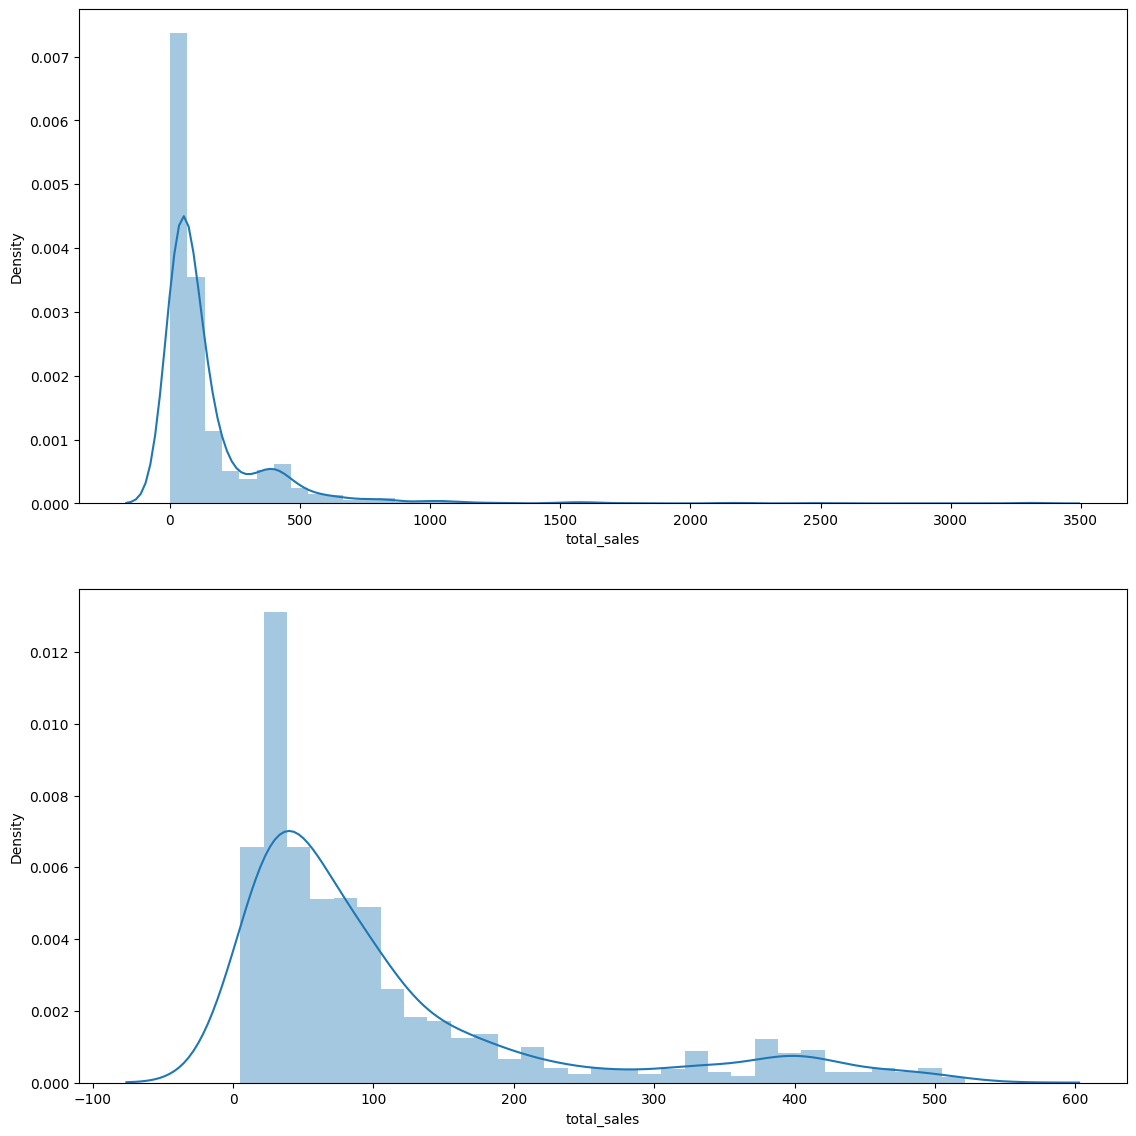

In [ ]:
#filtering out the extreme values
sales_threshold=np.percentile(Customer_table['total_sales'],[1,95])
sales_threshold_filter=np.logical_and(Customer_table['total_sales']>=sales_threshold[0],
                                      Customer_table['total_sales']<=sales_threshold[1])
sales_filtered=Customer_table.loc[sales_threshold_filter]
print(Customer_table.describe())
print(sales_filtered.describe())

fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
sns.distplot(Customer_table['total_sales'],
            ax=ax1)

ax2=fig.add_subplot(2,1,2)
sns.distplot(sales_filtered['total_sales'],
            ax=ax2)

fig.tight_layout(pad=3.0);

- 1. 판매 금액 분포 분석: 하위 1%, 상위 5%를 제외한 판매 금액대 분석

In [ ]:
#Most valuable customers

#filtering customer with top %10 purchase amount
top10perc_sales_amount=np.percentile(Customer_table['total_sales'],90)
filter_top10perc_sales_amount=Customer_table['total_sales']>=top10perc_sales_amount
top10perc_customers_with_hightest_turnover=Customer_table.loc[filter_top10perc_sales_amount]
regular_customers=Customer_table.loc[~filter_top10perc_sales_amount]

#calculating descriptive statistics
print('Top 10% customers Purchase Amount-Descriptive Statistics')
print('-'*50)
print(top10perc_customers_with_hightest_turnover['total_sales'].describe())
print('-'*50)
total_sales_amount=Customer_table['total_sales'].sum()
print('Total sales: {:,.0f}'.format(total_sales_amount))
total_sales_amount_top10perc=top10perc_customers_with_hightest_turnover['total_sales'].sum()
print('Total sales of top 10% customers: {:,.0f}'.format(total_sales_amount_top10perc))

#calculating descriptive statistics
print('Regular customers Purchase Amount-Descriptive Statistics')
print('-'*50)
print(regular_customers['total_sales'].describe())
print('-'*50)
total_sales_amount_regular_customers=regular_customers['total_sales'].sum()
print('Total sales of regular customers: {:,.0f}'.format(total_sales_amount_regular_customers))


Top 10% customers Purchase Amount-Descriptive Statistics
--------------------------------------------------
count     178.00
mean      677.08
std       450.64
min       400.76
25%       423.88
50%       502.78
75%       730.62
max     3,325.20
Name: total_sales, dtype: float64
--------------------------------------------------
Total sales: 253,877
Total sales of top 10% customers: 120,520
Regular customers Purchase Amount-Descriptive Statistics
--------------------------------------------------
count   1,503.00
mean       88.73
std        86.07
min         0.95
25%        29.45
50%        59.18
75%       111.31
max       398.91
Name: total_sales, dtype: float64
--------------------------------------------------
Total sales of regular customers: 133,357


1. 가치 고객 데이터 분석: total sales 상위 10% 고객 120,520명에 대한 구매 금액 통계 분석과 이를 제외한 일반 고객들의 구매 금액 통계 분석

Cluster Statistics
--------------------------------------------------
         count   mean    std    min    25%    50%    75%      max
cluster                                                          
0.00    952.00  39.75  21.37   0.95  25.71  33.66  56.37    85.51
1.00    121.00 323.76  50.59 229.24 279.54 331.51 372.91   398.91
2.00    430.00 131.02  38.90  86.21  95.74 117.75 161.47   225.75
3.00    178.00 677.08 450.64 400.76 423.88 502.78 730.62 3,325.20


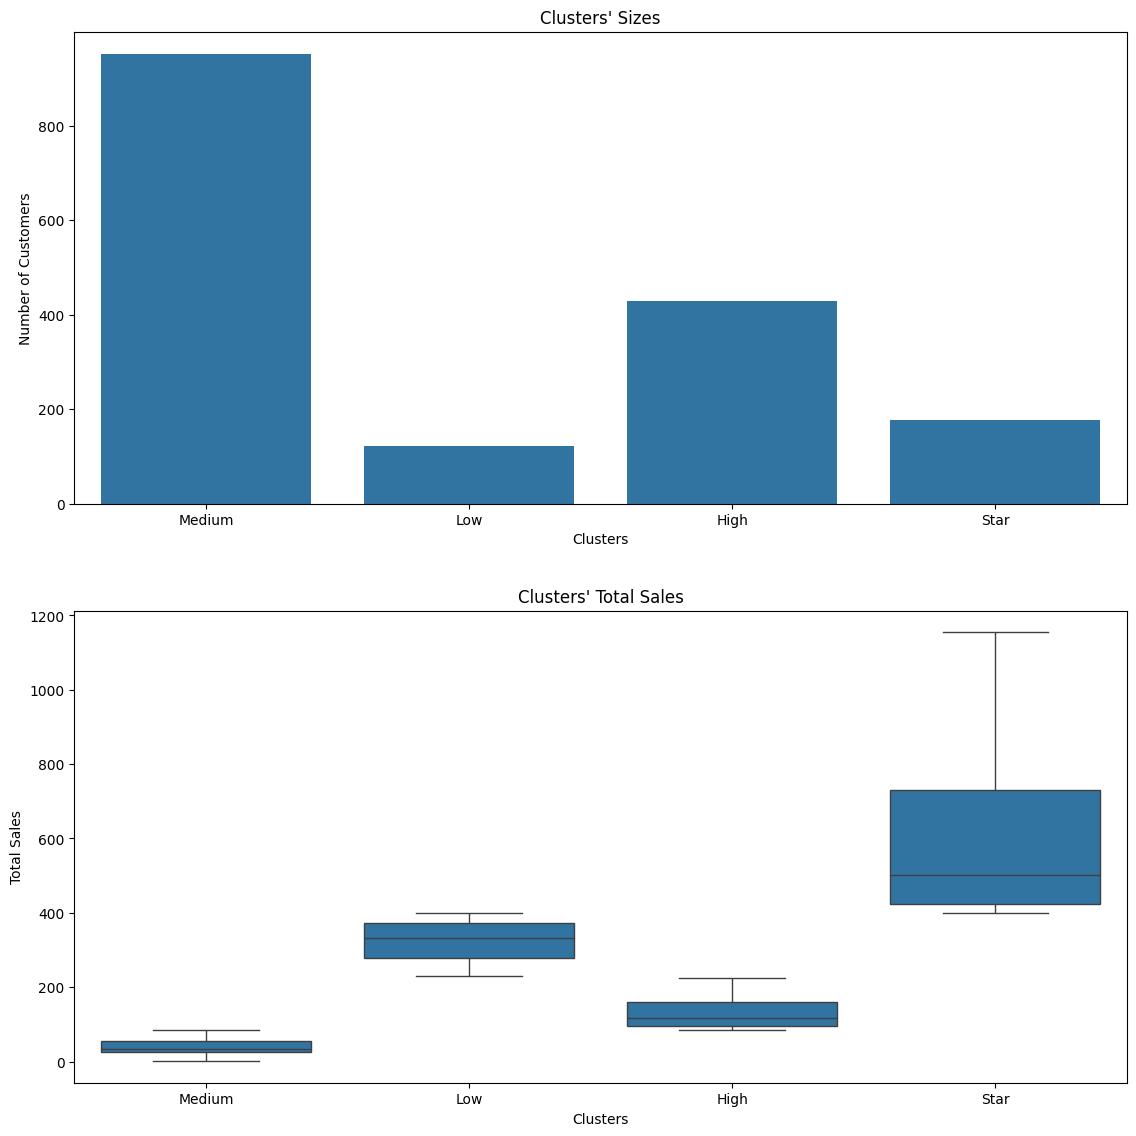

In [ ]:
#creating subsegments from regular customers
from sklearn.cluster import KMeans
X=regular_customers['total_sales'].values.reshape(-1,1)
regular_customers['cluster']=Clustering_KMeans=KMeans(n_clusters=3,random_state=15).fit_predict(X)

#merging clusters
Customer_table=pd.merge(left=Customer_table,
                        right=regular_customers[['user_id','cluster']],
                        how='left',
                        left_on='user_id',
                        right_on='user_id')
Customer_table['cluster'].fillna(3,inplace=True)

#Plotting the clusters
print('Cluster Statistics')
print('-'*50)
print(Customer_table.groupby(by=['cluster'])['total_sales'].describe())

fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
sns.countplot(x='cluster',data=Customer_table,ax=ax1)
plt.xlabel('Clusters')
plt.ylabel('Number of Customers')
plt.title("Clusters' Sizes")
ax1.set_xticklabels(['Medium','Low','High','Star']);

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x='cluster',y='total_sales',data=Customer_table,ax=ax2,showfliers = False)
plt.xlabel('Clusters')
plt.ylabel('Total Sales')
plt.title("Clusters' Total Sales")
fig.tight_layout(pad=3.0)
ax2.set_xticklabels(['Medium','Low','High','Star']);

- 1. 일반 고객 내 세그먼트 분석: 구매 금액에 따라 고객군을 군집화 

In [30]:
#creating a filter for shoppers 
shopper_filter=dataset['event_type']=='purchase'
#using the filter to create shopper user list
shopper_list=dataset.loc[shopper_filter,['user_id']]
#distincting shopper customer list
distinct_shopper_df=pd.DataFrame(shopper_list['user_id'].unique(),columns=['user_id'])
#creating shopper dataset
dataset_shoppers=pd.merge(left=dataset,
                          right=distinct_shopper_df,
                          how='inner',
                          left_on=['user_id'],
                          right_on=['user_id']
                          )


In [34]:
dataset_shoppers

,user_id,item_id,user_session,event_time,category_code,brand,price,event_type,category_level_1
0,b6925cb4-fce6-4d5c-b6b3-d4a28bd05a1f,efedb674-e71c-4ead-8635-80e20534b6c5,0000ee88-5087-46cc-a002-296abe804689,2019-12-16 11:35:48+00:00,apparel.shoes.sandals,respect,86.23,purchase,apparel
1,b6925cb4-fce6-4d5c-b6b3-d4a28bd05a1f,efedb674-e71c-4ead-8635-80e20534b6c5,010d15e7-3456-4c41-b502-192f9c2dc0ee,2019-12-15 12:02:16+00:00,apparel.shoes.sandals,respect,86.23,purchase,apparel
2,b6925cb4-fce6-4d5c-b6b3-d4a28bd05a1f,cfde4f77-b62d-4276-8875-01c13f035e2f,0a0a2d6b-9fd5-4556-863e-d71274b0694d,2019-12-14 09:01:54+00:00,apparel.shoes.moccasins,respect,86.23,view,apparel
3,b6925cb4-fce6-4d5c-b6b3-d4a28bd05a1f,efedb674-e71c-4ead-8635-80e20534b6c5,0a0a2d6b-9fd5-4556-863e-d71274b0694d,2019-12-14 09:02:38+00:00,apparel.shoes.sandals,respect,86.23,view,apparel
4,b6925cb4-fce6-4d5c-b6b3-d4a28bd05a1f,f151bf67-381f-4c8a-a480-3f556624026f,0a0a2d6b-9fd5-4556-863e-d71274b0694d,2019-12-14 09:03:33+00:00,apparel.shoes,respect,95.24,view,apparel
...,...,...,...,...,...,...,...,...,...
63917,5bd87ae2-17b7-4471-bdd3-8ed2615fe4c5,bd4cfc15-a4b7-4349-873a-1cb0f40b1e55,f1d9880f-875d-4ccc-ac83-802f0fc0ac7b,2019-12-27 09:25:27+00:00,apparel.shoes,rooman,49.16,view,apparel
63918,5bd87ae2-17b7-4471-bdd3-8ed2615fe4c5,f0d59ccc-c51b-4fdf-a5a8-9ef477b791a2,f1d9880f-875d-4ccc-ac83-802f0fc0ac7b,2019-12-27 09:25:47+00:00,apparel.shoes.moccasins,rooman,53.80,view,apparel
63919,5bd87ae2-17b7-4471-bdd3-8ed2615fe4c5,515d389d-20de-4525-a9fd-45b004881aec,f1d9880f-875d-4ccc-ac83-802f0fc0ac7b,2019-12-27 09:26:15+00:00,apparel.shoes,johnrichardo,76.19,view,apparel
63920,5bd87ae2-17b7-4471-bdd3-8ed2615fe4c5,3e3f8870-82f5-49e2-965f-852cef74b680,f1d9880f-875d-4ccc-ac83-802f0fc0ac7b,2019-12-27 09:26:31+00:00,apparel.shoes.keds,nike,176.30,view,apparel


In [39]:
#Extracting category code level_1 from category code
dataset_shoppers['category_level_1']=dataset_shoppers['category_code'].apply(extract_categorycode)
#excluding unknown categories
filter_temp=dataset_shoppers['category_level_1']=='Unknown'
dataset_shoppers=dataset_shoppers.loc[~filter_temp]

#creating shoppers visit table that contains number of visits in each category 
shoppers_visit_table=dataset_shoppers.groupby(by=['user_id','category_level_1']).agg(Number_of_view=('user_id','count'))
shoppers_visit_table=shoppers_visit_table.reset_index()

#creating shoppers visit frequency table that contains total number of visit overall.
shoppers_visit_frequency=shoppers_visit_table.groupby(by=['user_id']).agg(n_visits=('Number_of_view','sum')).reset_index()

#creating the ratio column in shopper visit table 
shoppers_visit_table=pd.merge(left=shoppers_visit_table,
                              right=shoppers_visit_frequency,
                              left_on='user_id',
                              right_on='user_id',
                              how='left')
shoppers_visit_table['ratio']=shoppers_visit_table['Number_of_view']/shoppers_visit_table['n_visits']

In [45]:
shoppers_visit_table

,user_id,category_level_1,Number_of_view,n_visits,ratio
0,002427d7-3da1-4d79-aca9-32f063b179bc,shoes,21,21,1.00
1,004c1dc7-7935-4631-9956-2583e99d4dc5,costume,2,57,0.04
2,004c1dc7-7935-4631-9956-2583e99d4dc5,shoes,53,57,0.93
3,004c1dc7-7935-4631-9956-2583e99d4dc5,trousers,1,57,0.02
4,004c1dc7-7935-4631-9956-2583e99d4dc5,tshirt,1,57,0.02
...,...,...,...,...,...
4775,ff5798bc-fa55-448d-8b68-59640b4f0150,scarf,3,11,0.27
4776,ff5798bc-fa55-448d-8b68-59640b4f0150,shoes,7,11,0.64
4777,ff5798bc-fa55-448d-8b68-59640b4f0150,sock,1,11,0.09
4778,ffd9366a-3bf3-4f34-89a9-01dc2c76a6f8,scarf,1,44,0.02


In [44]:
focused_shoppers['category_level_1'].value_counts()

category_level_1
shoes        447
trousers      16
shirt         12
underwear     11
costume        8
scarf          7
tshirt         3
jeans          3
shorts         3
glove          2
jumper         1
sock           1
jacket         1
pajamas        1
Name: count, dtype: int64

In [53]:
'''
spliting shoppers into 2 different groups to create more homogenious interest groups. 
First group contains shoppers interested with only on category and the second group contains shoppers visited multiple categories.
'''
#creating first shopper group, focused customers.
focused_shoppers_filter=shoppers_visit_table['ratio']==1
focused_shoppers=shoppers_visit_table.loc[focused_shoppers_filter]
#assigning "focused customers" to seperate groups by their category interests
focused_shoppers['shoppers_interest_groups']=pd.factorize(focused_shoppers['category_level_1'])[0]+1

#creating second customer group, diversified customers.
diversified_shoppers=shoppers_visit_table.loc[~focused_shoppers_filter]
diversified_shoppers_pivot=pd.pivot_table(data=diversified_shoppers,values='ratio',index='user_id',columns='category_level_1')
diversified_shoppers_pivot.fillna(0,inplace=True)
diversified_shoppers_pivot.reset_index(inplace=True)

#creating subgroups for "diversified customers"
k_4_clusters=create_clusters(input_data_frame=diversified_shoppers_pivot,
                             input_columns=['shoes', 'trousers', 'shirt', 'underwear','costume', 'scarf', 'tshirt', 'jeans', 'shorts','glove', 'jumper', 'sock', 'jacket','pajamas'],
                             n_cluster=4)

diversified_shoppers_pivot['cluster_k4means']=k_4_clusters

#profiling subgroups of diversified customers
input_columns=['cluster_k4means', 'shoes', 'trousers', 'shirt', 'underwear','costume', 'scarf', 'tshirt', 'jeans', 'shorts','glove', 'jumper', 'sock', 'jacket','pajamas']                          
print(diversified_shoppers_pivot[input_columns].groupby(by='cluster_k4means').mean())
print(diversified_shoppers_pivot['cluster_k4means'].value_counts())


category_level_1  shoes  trousers  shirt  underwear  costume  scarf  tshirt  \
cluster_k4means                                                               
0                  0.81      0.03   0.03       0.02     0.03   0.02    0.01   
1                  0.33      0.02   0.50       0.02     0.06   0.01    0.01   
2                  0.32      0.57   0.01       0.01     0.02   0.01    0.01   
3                  0.35      0.02   0.03       0.09     0.13   0.12    0.05   

category_level_1  jeans  shorts  glove  jumper  sock  jacket  pajamas  
cluster_k4means                                                        
0                  0.01    0.01   0.00    0.00  0.00    0.00     0.00  
1                  0.00    0.01   0.00    0.01  0.00    0.00     0.01  
2                  0.01    0.03   0.01    0.00  0.01    0.00     0.01  
3                  0.03    0.09   0.01    0.01  0.02    0.00     0.02  
cluster_k4means
0    724
3    288
1     78
2     75
Name: count, dtype: int64


'\ndiversified shoppers subgroups\n0: 70k-appliances and mostly electronics\n1: 30k-electronics and mostly appliances\n2: 30k-Apparel, appliances, construction, electronics, furniture\n3: 11k- Electronics and mostly computers\n'

상품 카테고리에 따른 유저들의 구매 분석
- cluster0: 724명의 유저, shoes를 가장 많이 구매함
- cluster1: 78명의 유저, shirts를 가장 많이 구매함
- cluster2: 75명의 유저, trousers를 가장 많이 구매함, shorts, jeans에도 관심이 많음 
- cluster3: 288명의 유저, underwear, costume. scarf등의 의류 및 액세서리 제품들에 관심이 많고 sock, jumper, pajamas 와 같은 편의 제품에 관심이 많음

In [ ]:


#making space in the memory for category analysis
del focused_shoppers
del diversified_shoppers
del diversified_shoppers_pivot
del distinct_shopper_df
del Customer_table
del daily_summary_table



## Category Analysis

In [54]:
#splitting the category text into 2 pieces as category and subcategory
dataset['category']=dataset['category_code'].apply(extract_categorycode,level=0)
dataset['subcategory']=dataset['category_code'].apply(extract_categorycode,level=1)